In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
!pip install pretty_midi

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pathlib
import pretty_midi
import os

# import kmeans model
from sklearn.cluster import KMeans

import plotly.graph_objects as go

In [4]:
def analyze_midi(midi_file):

    pm = pretty_midi.PrettyMIDI(midi_file)

    # get tempo changes
    tempo_changes = pm.get_tempo_changes()
    bpm = np.mean(tempo_changes)

    # get notes
    notes = []
    for instrument in pm.instruments:
        for note in instrument.notes:
            notes.append(note)

    # get notes steps
    sorted_notes = sorted(notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    steps = []
    for note in sorted_notes:
        start = note.start
        steps.append(start - prev_start)
        prev_start = start
    avg_step = np.mean(steps)
    max_step = np.max(steps)
    std_step = np.std(steps)


    # get note durations
    durations = [note.end - note.start for note in notes]
    # get average duration
    avg_duration = np.mean(durations)
    max_duration = np.max(durations)
    std_duration = np.std(durations)

    # get note pitches
    pitches = [note.pitch for note in notes]
    # get average pitch
    avg_pitch = np.mean(pitches)
    max_pitch = np.max(pitches)
    std_pitch = np.std(pitches)


    return {
        'avg_step': avg_step,
        'max_step': max_step,
        'std_step': std_step,
        'avg_duration': avg_duration,
        'max_duration': max_duration,
        'std_duration': std_duration,
        'avg_pitch': avg_pitch,
        'max_pitch': max_pitch,
        'std_pitch': std_pitch
    }

Use the MAESTRO and the VGMIDI Dataset, with a total of more than 3700 files to train the model and identify two major clusters.

In [5]:
maestroDirPath = '/content/drive/MyDrive/Music Generator/maestro-v3.0.0'
maestroFolders = [folder for folder in os.listdir(maestroDirPath) if os.path.isdir(os.path.join(maestroDirPath, folder))]
maestroDataset = []
for dir in maestroFolders:
    filesDir = maestroDirPath + '/' + dir + '/*.midi'
    maestroDataset.append(glob.glob(filesDir))


vgmidiDirPath = '/content/drive/MyDrive/Music Generator/clean/unlabelled'
vgmidiFolders = [folder for folder in os.listdir(vgmidiDirPath) if os.path.isdir(os.path.join(vgmidiDirPath, folder))]
vgmidiDataset = []
for dir in vgmidiFolders:
    filesDir = vgmidiDirPath + '/' + dir + '/*.mid'
    vgmidiDataset.append(glob.glob(filesDir))

files = []
for dir in maestroDataset:
    for file in dir:
        files.append(file)

for dir in vgmidiDataset:
  for file in dir:
    files.append(file)

print(len(files))

3796


In [6]:
train_dataset = np.empty((len(files), 9), dtype=float)
for file_ind in range(len(files)):
    data = analyze_midi(files[file_ind])

     # Convert the dictionary values to a NumPy array
    data = np.array(list(data.values())).reshape(1, -1)

    # Stack the data array vertically into train_dataset
    train_dataset[file_ind] = data

print('trainDataset shape: ', train_dataset.shape)

trainDataset shape:  (3796, 9)


In [8]:
# Create a kmeans model on data, using k = 2
kmeans_model = KMeans(n_clusters=2, random_state=42)
cluster_assignments = kmeans_model.fit_predict(train_dataset)

# These are labels for each cluster: 0 and 1
labels = kmeans_model.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


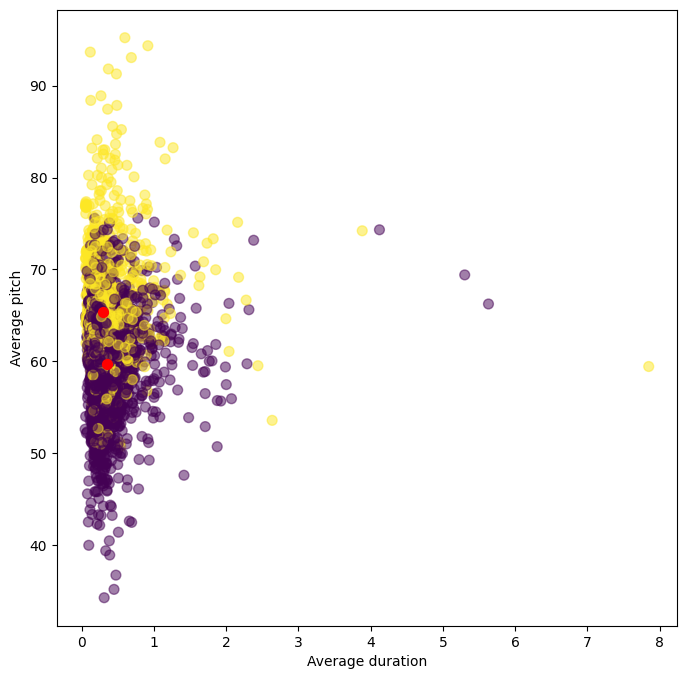

In [9]:
# visualize the clustering
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(train_dataset[:, 3], train_dataset[:, 6], c=labels, cmap='viridis', s=50, alpha=0.5)
ax.scatter(kmeans_model.cluster_centers_[:, 3], kmeans_model.cluster_centers_[:, 6], c='red', s=50)
ax.set_xlabel('Average duration')
ax.set_ylabel('Average pitch')
plt.show()

In [10]:
print(np.bincount(labels))

[2158 1638]


In [11]:
# Create an interactive 3D scatter plot using plotly
fig = go.Figure()

# Scatter plot for each sub-cluster in 3D
for cluster_num in np.unique(cluster_assignments):
    sub_cluster_indices = np.where(cluster_assignments == cluster_num)[0]
    fig.add_trace(go.Scatter3d(
        x=train_dataset[sub_cluster_indices, 6],
        y=train_dataset[sub_cluster_indices, 7],
        z=train_dataset[sub_cluster_indices, 8],
        mode='markers',
        marker=dict(size=6),
        name=f'Sub-Cluster {cluster_num}'
    ))

# Plot cluster centers in red
fig.add_trace(go.Scatter3d(
    x=kmeans_model.cluster_centers_[:, 6],
    y=kmeans_model.cluster_centers_[:, 7],
    z=kmeans_model.cluster_centers_[:, 8],
    mode='markers',
    marker=dict(size=10, color='green', symbol='cross'),
    name='Cluster Centers'
))

fig.update_layout(
    scene=dict(
        xaxis=dict(title='Feature 1'),
        yaxis=dict(title='Feature 2'),
        zaxis=dict(title='Feature 3'),
    ),
    title='3D Scatter Plot of Sub-Clusters'
)

fig.show()

classify a new point

In [12]:
new_file = '/content/drive/MyDrive/Music Generator/clean/fake_top_k/train/e0_fake_generated_piece_164.mid'
new_midi_file = analyze_midi(new_file)

new_midi_values = np.array([value for value in new_midi_file.values()])

# Calculate distances to cluster centroids
distances = kmeans_model.transform(new_midi_values.reshape(1, -1))

# Find the index of the nearest cluster centroid
nearest_cluster_index = np.argmin(distances)

# Now we have the index of the nearest cluster centroid,
# use it to classify the new point
predicted_label = nearest_cluster_index
print("Predicted label for the new point:", predicted_label)
print("Predicted distance for the new point:", distances)

Predicted label for the new point: 0
Predicted distance for the new point: [[11.53828027 27.59824079]]


Save the trained model

In [13]:
import pickle

with open("/content/drive/MyDrive/Music Generator/model.pkl", "wb") as f:
    pickle.dump(kmeans_model, f)